<a href="https://colab.research.google.com/github/NipuniSdSR/NODE/blob/main/01_NODE_circle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# System: Circle


Circle as a function with center: (a,b), radius: r:

$(x-a)^2 + (y-b)^2 = r^2$

ODE representaion of circle using parameter t

$(x-a)x' + (y-b)y' = 0$

$
  x' = -y + b\\
  y' =  x - a
$

 Let's build a Neural ODE to build the circle 

In [ ]:
# Import the packages

%pip install torchdiffeq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
from tqdm.notebook import tqdm
import time

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# ODE model
"""
Here using given ODE solver, ODE will solve step wise and  will return solution
Solver: We can make our own solvers such as Euler, RK4 or we can use
'torchdiffeq' module solvers
1. odeint
2. adjoint_odeint 
"""

# Neural ODE model
class NeuralODE(nn.Module):
  def __init__(self, func):
    super().__init__()
    self.func = func

  def forward(self, y0, t, solver):
    solution = torch.empty(len(t), *y0.shape, dtype=y0.dtype, device=y0.device)
    solution[0] = y0

    j = 1
    for t0, t1 in zip(t[:-1], t[1:]):
      dy =  solver(self.func, t0, t1-t0, y0 )
      y1 = y0 + dy
      solution[j] = y1
      j +=1
      y0 = y1

      
    return solution

In [ ]:
def euler(func, t, dt, y):

  return func(t,y)*dt

In [ ]:
# radius and center of the circle
r = 7.
a = 1.
b = 1.

true_A = torch.tensor([[0., -1.], [1., 0.]])
true_B = torch.tensor([[b],[-a]])


class dif_circle(nn.Module):
  def forward(self, t, y):
    return torch.add(torch.mm( true_A, y),true_B)

y0 = torch.tensor([[a + r], [b]])
t = torch.linspace(0, 2*np.pi, 200)

In [ ]:
# print(true_A)
# print(y0)
# print(torch.add(torch.mm( true_A, y0.T),true_B).T)

In [ ]:
ode_test = NeuralODE(func= dif_circle())
test_result = ode_test(y0=y0, t=t, solver=euler)

# make sure you transpose
test_result = test_result.transpose(0, 1)

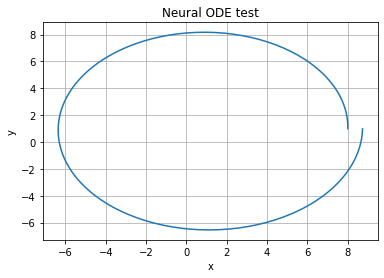

In [ ]:
# visualize result
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Neural ODE test')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.plot(test_result[0].detach().numpy(), test_result[1].detach().numpy())
plt.grid(True)
plt.show()

## 1. Solver 1
### RK4

In [ ]:
def rk4(func, t, dt, y):
  _one_sixth = 1/6
  half_dt = dt * 0.5

  k1 = func(t,y)
  k2 = func(t + dt/2, y + dt/2*k1)
  k3 = func(t + dt/2, y + dt/2*k2)
  k4 = func(t+dt,y+dt*k3)
  
  return (k1 + 2 * (k2 + k3) + k4) * dt * _one_sixth 

In [ ]:
data_size = 500
y0 = torch.tensor([[a + r, b]])
t = torch.linspace(0, 2*np.pi, data_size)


class dif_circle(nn.Module):
  def forward(self, t, y):
    return torch.add(torch.mm( true_A, y.T),true_B).T


with torch.no_grad():
  node = NeuralODE(func=dif_circle())
  true_y = node(y0=y0, t=t, solver=euler)


In [ ]:

true_y.shape

torch.Size([500, 1, 2])

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

#file saving location
images_dir = '/content/gdrive/My Drive/Colab Notebooks/NODE/03/periodic_systems/01_NODE_results/'

Mounted at /content/gdrive


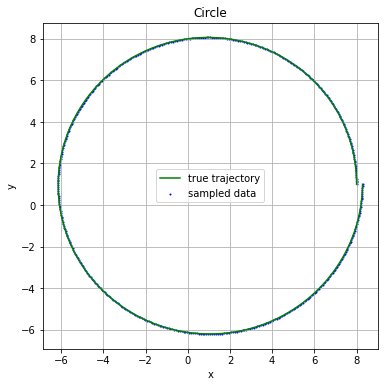

In [ ]:

def visualize(true_y, pred_y=None, itr = 00):
  fig = plt.figure(figsize=(6, 6), facecolor='white')
  ax = fig.add_subplot(111)
  ax.set_title('Circle')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.plot(true_y.numpy()[:, 0, 0], true_y.numpy()[:, 0, 1],'green', label='true trajectory')
  ax.scatter(true_y.numpy()[:, 0, 0], true_y.numpy()[:, 0, 1], color='blue', label='sampled data',s=1)
  if pred_y is not None:
    ax.plot(pred_y.numpy()[:,0,0], pred_y.numpy()[:,0,1], 'red', label='learned trajectory')
  plt.savefig(images_dir +'circle' + str(itr) + '.png')
  plt.legend()
  plt.grid(True)
  plt.show()

visualize(true_y)

In [ ]:
 
batch_time = 10
batch_size = 16

def get_batch():
  s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
  batch_y0 = true_y[s]  # (batch_size, 1, emb)
  batch_t = t[:batch_time]  # (T)
  batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (time, batch_size, 1, emb)
  return batch_y0, batch_t, batch_y

In [ ]:
# define dynamic function
class ODEFunc(nn.Module):
  def __init__(self):
    super().__init__()
    ### TO-DO: Make your own ODE network!
    self.net = nn.Sequential(nn.Linear(2, 50),
                              nn.Tanh(),
                              nn.Linear(50,2))
    
    for m in self.net.modules():
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=0.1)
        nn.init.constant_(m.bias, val=0)

  def forward(self, t, y):
    output = self.net(y)
    return output

In [ ]:
## Train
niters = 400

node = NeuralODE(func=ODEFunc())
optimizer = optim.RMSprop(node.parameters(), lr=1e-3)

start_time = time.time()

for iter in tqdm(range(niters + 1)):
  optimizer.zero_grad()
  batch_y0, batch_t, batch_y = get_batch()
  # print(batch_y0.shape, batch_t.shape, batch_y.shape)

  pred_y = node(y0=batch_y0, t=batch_t, solver=rk4)
  loss = torch.mean(torch.abs(pred_y - batch_y))
  loss.backward()
  optimizer.step()

  if iter % 50 == 0:
    with torch.no_grad():
      pred_y = node(y0, t, solver=rk4)
      print(pred_y.shape)
      loss = torch.mean(torch.abs(pred_y - true_y))
      print('Iter {:04d} | Total Loss {:.6f}'.format(iter, loss.item()))
      visualize(true_y, pred_y, iter)

end_time = time.time() - start_time
print('process time: {} sec'.format(end_time))

## 1. Solver 2
### oddeint

  0%|          | 0/401 [00:00<?, ?it/s]

torch.Size([500, 1, 2])
Iter 0000 | Total Loss 6.083458


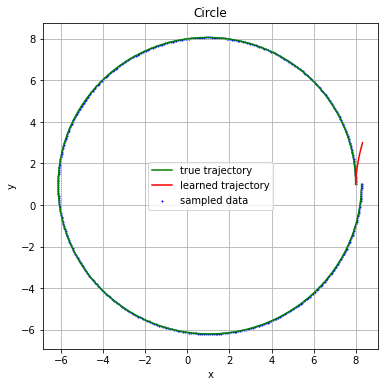

torch.Size([500, 1, 2])
Iter 0050 | Total Loss 2.574489


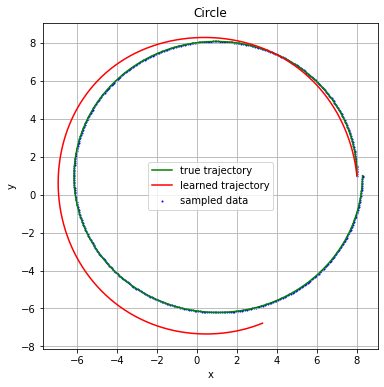

torch.Size([500, 1, 2])
Iter 0100 | Total Loss 0.226701


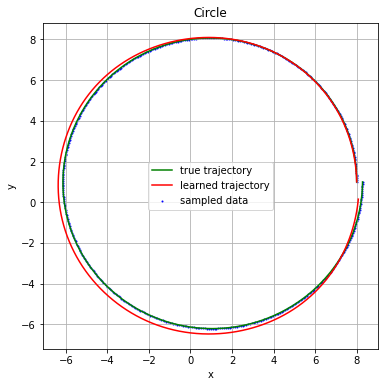

torch.Size([500, 1, 2])
Iter 0150 | Total Loss 0.137577


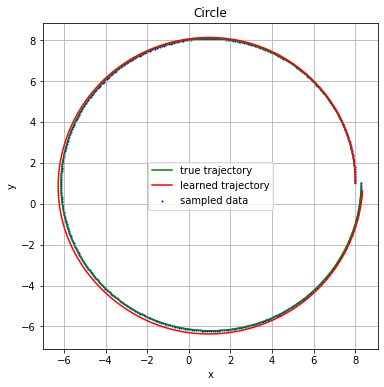

torch.Size([500, 1, 2])
Iter 0200 | Total Loss 0.174525


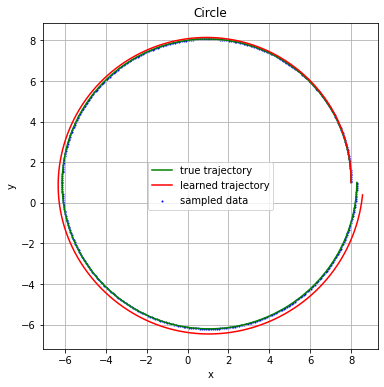

torch.Size([500, 1, 2])
Iter 0250 | Total Loss 0.060692


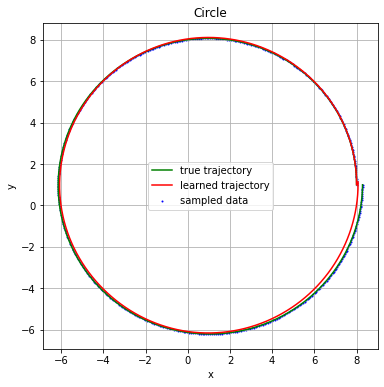

torch.Size([500, 1, 2])
Iter 0300 | Total Loss 0.157702


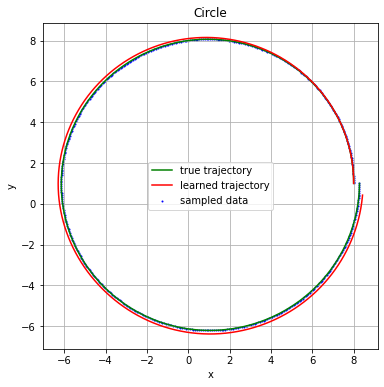

torch.Size([500, 1, 2])
Iter 0350 | Total Loss 0.107165


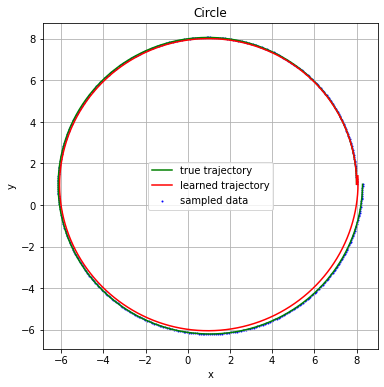

torch.Size([500, 1, 2])
Iter 0400 | Total Loss 0.095977


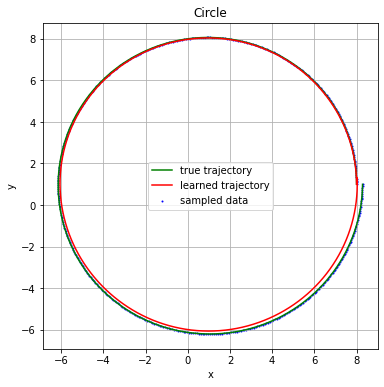

process time: 12.176657676696777 sec


In [ ]:
## Train
from torchdiffeq import odeint
niters = 400

func=ODEFunc()
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

start_time = time.time()

for iter in tqdm(range(niters + 1)):
  optimizer.zero_grad()
  batch_y0, batch_t, batch_y = get_batch()
  pred_y = odeint(func = func, y0=batch_y0, t=batch_t, rtol=1e-7, atol=1e-9, method='dopri5')
  loss = torch.mean(torch.abs(pred_y - batch_y))
  loss.backward()
  optimizer.step()

  if iter % 50 == 0:
    with torch.no_grad():
      pred_y = odeint(func, y0, t, rtol=1e-7, atol=1e-9, method='dopri5')
      print(pred_y.shape)
      loss = torch.mean(torch.abs(pred_y - true_y))
      print('Iter {:04d} | Total Loss {:.6f}'.format(iter, loss.item()))
      visualize(true_y, pred_y)

end_time = time.time() - start_time
print('process time: {} sec'.format(end_time))

In [ ]:
## Train
from torchdiffeq import odeint_adjoint as odeint
niters = 400

func=ODEFunc()
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

start_time = time.time()

for iter in tqdm(range(niters + 1)):
  optimizer.zero_grad()
  batch_y0, batch_t, batch_y = get_batch()
  pred_y = odeint(func = func, y0=batch_y0, t=batch_t, rtol=1e-7, atol=1e-9, method='dopri5')
  loss = torch.mean(torch.abs(pred_y - batch_y))
  loss.backward()
  optimizer.step()

  if iter % 50 == 0:
    with torch.no_grad():
      pred_y = odeint(func, y0, t, rtol=1e-7, atol=1e-9, method='dopri5')
      print(pred_y.shape)
      loss = torch.mean(torch.abs(pred_y - true_y))
      print('Iter {:04d} | Total Loss {:.6f}'.format(iter, loss.item()))
      visualize(true_y, pred_y, iter, iter)

end_time = time.time() - start_time
print('process time: {} sec'.format(end_time))

  0%|          | 0/401 [00:00<?, ?it/s]

torch.Size([500, 1, 2])
Iter 0000 | Total Loss 6.817330


TypeError: ignored